# 6. Classification, Regression
This section will cover logistic regression (which is a classification model, not regression) and linear regression. Once you can train both of these models, you know how to do both classification and regression in their simplest way possible. I first demonstrate how to train a logistic regression using the Iris dataset. As an exercise, you will train a linear regression on the Boston housing dataset.

This section will put together what we've learned so far, e.g. `session`, `placeholder`, `variable`, etc. This section might seem hard at first, but the only new concept that will be introduced here is the `GradientDescentOptimizer`. As long as you understand the code step by step, it should be ok.

## Logistic Regression

This example is partially adopted from [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.12/tutorials/mnist/pros/) tutorial from TensorFlow official website.

### Task

Classify a dataset of hand-written digits (0 through 9).

### Data

Let's load the data first. Thankfully, TensorFlow provided us a nice API. The data is also already split into train, validation and test set. In general, the data is much less clean.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at the first image to get a sense of what is inside. Note that `next_batch` is an API provided by TensorFlow to get the next `n` images from the dataset. You generally have to code this up yourself.

In [2]:
batch = mnist.train.next_batch(1) # get one image from the data
plotData = batch[0]
plotData

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

There are $28\times 28=784$ pixels. $0$ means black and $1$ means white. Let's reshape it and use `matplotlib` to make it an image.

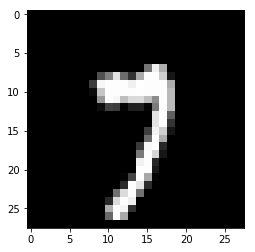

In [3]:
plotData = plotData.reshape(28, 28) # reshape to make image a matirx
plt.gray() # use this line if you don't want to see it in color
plt.imshow(plotData)
plt.show()

### Overview

We will build a softmax regression. Softmax regression is just a multi-class generalization of the logistic regression model:

$Y=softmax(XW+b)$
where

$Y: N \times K$. Labels. The labels are one-hot encoded.

$X: N \times M$. Features.

$W: M \times K$. Weights.

$b: K$. Bias

Here, $N$ can either be the train, validation, test sample size or the mini-batch size, depending on which part of the process you're in. $M$ is the number of features (784 in this case) and $K$ is the number of classes (10 in this case).

I really like to write down all the matrix dimensions before I start any coding. This way, I can avoid matrix dimension errors later on. This is kind of like creating an outline of your essay before you start drafting it.

The loss we would like to optimize is the cross-entropy loss, averaged over the sample size:

$$\frac{-\sum_{n=1}^N \sum_{k=1}^K y_{n,k} log(\hat{y}_{n,k})}{N}$$

We will train this using gradient descent. 

Coding of this model is a six step process:
1. Define variables and placeholders.
2. Define the model.
3. Define the loss function.
4. Define the optimizer.
5. Train the model, i.e. initialize variables and run optimizer.
6. Evaluate the model.

This is the same for any other models. Neural nets will have these steps too!

### Variables and Placeholders

$Y,X$ will be a placeholder, because we will feed in datasets with different shapes.

In [4]:
M = 784
K = 10

In [5]:
X = tf.placeholder(tf.float32, shape=[None, M])
Y = tf.placeholder(tf.float32, shape=[None, K])

$W,b$ will be variables, because we would like to mutate them every epoch via the gradient descent.

In [6]:
W = tf.Variable(tf.zeros([M, K])) # the variables will be all zeros initially
b = tf.Variable(tf.zeros([K]))

### Model
Softmax regression model is a one liner!

In [7]:
Yhat = tf.nn.softmax(X @ W + b)

### Loss
The cross-entropy loss is also a one liner! Make sure to compare it with the equation above and check that it's doing what it's supposed to. We will also define accuracy for evaluating the result on the test set.

In [8]:
loss               = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(Yhat), axis=1))
# choose predictions from 10 classes and compare them with the true labels
correct_prediction = tf.equal(tf.argmax(Yhat, 1), tf.argmax(Y, 1))           
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) 

### Optimizer
Here's somethig new to learn! `GradientDescentOptimizer` takes in the objective that we would like to minimize. When we run this optimizer in a session, it will look for all trainable variables (or the specified list of variables, if any) and update them. There are many other optimizers e.g. `AdagradOptimizer`, `AdamOptimizer`. Find your favorite!

In [9]:
learning_rate = 0.01 # this is a hyperparameter to tune
optimizer = tf.train.GradientDescentOptimizer(learning_rate) # first initialize an optimizer
update = optimizer.minimize(loss) # then pass in the objective you would like to minimize

### Initialize variables and run optimizer, evaluate the model
The final step is to train the model, and then to evaluate it. We do these in one go. 
We have 25 epochs. Within each epoch, we go through the dataset batch by batch. In each bath, we `sess.run` two variables: `update` and `loss`. Running `update` applies backpropagation to the graph and updates the variables relevant to minimizing the objective. In this case `W` and `b` are updated. Running `loss` just extracts the objective so that we can keep track of how well our model is being trained.

In [10]:
num_epochs  = 25
batch_size  = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # remember, you need to initialize variables first
    total_batch = int(mnist.train.num_examples/batch_size)
    for epoch in range(num_epochs):
        average_cost = 0 # print cost per epoch
        for _ in range(total_batch):
            batch_X, batch_Y = mnist.train.next_batch(batch_size)
            _, c = sess.run([update, loss], feed_dict={X: batch_X, 
                                                          Y: batch_Y}) # evaluate `update` and `loss`
            average_cost += c / total_batch
        print("Epoch:",epoch,"Cost:",average_cost)
        
    print("Test Accuracy:", accuracy.eval({X: mnist.test.images, Y: mnist.test.labels}))

Epoch: 0 Cost: 1.1837944513
Epoch: 1 Cost: 0.665343354128
Epoch: 2 Cost: 0.552922634807
Epoch: 3 Cost: 0.498772344047
Epoch: 4 Cost: 0.465558629795
Epoch: 5 Cost: 0.442648443471
Epoch: 6 Cost: 0.425598685687
Epoch: 7 Cost: 0.412232228843
Epoch: 8 Cost: 0.401439684359
Epoch: 9 Cost: 0.392432119738
Epoch: 10 Cost: 0.384814032018
Epoch: 11 Cost: 0.378210317005
Epoch: 12 Cost: 0.372440685115
Epoch: 13 Cost: 0.367294720736
Epoch: 14 Cost: 0.362738664773
Epoch: 15 Cost: 0.358654151478
Epoch: 16 Cost: 0.354902698181
Epoch: 17 Cost: 0.35149155083
Epoch: 18 Cost: 0.348347141445
Epoch: 19 Cost: 0.345404652953
Epoch: 20 Cost: 0.342739603519
Epoch: 21 Cost: 0.340292761651
Epoch: 22 Cost: 0.337950857038
Epoch: 23 Cost: 0.335738606128
Epoch: 24 Cost: 0.33371479877
Test Accuracy: 0.9138


### Done!
We have 92% ish accuracy. How good is this? To cite the `TensorFlow` documentation:

> Getting 92% accuracy on MNIST is bad. It's almost embarrassingly bad. In this section, we'll fix that, jumping from a very simple model to something moderately sophisticated: a small convolutional neural network. This will get us to around 99.2% accuracy -- not state of the art, but respectable.

We are not going to introduce CNNs in this workshop, but you should take a look to aim for 99+% accuracy!

## Exercise
Train a linear regression using gradient descent (no closed form!) that predicts housing prices in Boston from other covariates provided. Follow the six steps above. Plot the loss and observe that it goes down.

(Optional) Fit a LASSO. Fit a Ridge.

In [11]:
from sklearn.datasets import load_boston
import pandas as pd
boston = load_boston()

In [12]:
df = pd.DataFrame(boston.data)
df.columns = boston.feature_names
df['PRICE'] = boston.target

In [13]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [7]:
import numpy as np

In [8]:
M = df.shape[1]
N = df.shape[0]

In [9]:
X = tf.placeholder(tf.float32, shape=[None, M])
Y = tf.placeholder(tf.float32, shape=[None, 1])

In [10]:
W = tf.Variable(tf.ones([M, 1]))

In [11]:
Yhat = X @ W

In [12]:
loss = tf.reduce_mean((Y-Yhat)**2)
# regularizer = tf.contrib.layers.l1_regularizer(scale=0.1)
# regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
# regularization_penalty = tf.contrib.layers.apply_regularization(regularizer, [W])
# loss += regularization_penalty
optimizer = tf.train.GradientDescentOptimizer(0.01)
update = optimizer.minimize(loss)

In [13]:
X_np = df.iloc[:,:-1].as_matrix()
X_np = (X_np - np.mean(X_np,axis=0)) / np.std(X_np,axis=0)
X_np = np.hstack((X_np,np.ones([X_np.shape[0],1])))
y_np = df.iloc[:,-1].as_matrix()[:,np.newaxis]

In [14]:
np.random.seed(1)
train_indices = np.random.rand(X_np.shape[0]) < 0.80
X_train = X_np[train_indices]
X_test  = X_np[~train_indices]
y_train = y_np[train_indices]
y_test  = y_np[~train_indices]

In [15]:
num_epochs  = 1000
losses = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        _, c = sess.run([update, loss], feed_dict={X: X_train, 
                                                      Y: y_train})
        losses.append(c)
        print("Epoch:",epoch,"Cost:",c)
    test_loss = sess.run(loss, feed_dict={X: X_test, 
                                          Y: y_test})
    print("Test Loss:",test_loss)

Epoch: 0 Cost: 604.989
Epoch: 1 Cost: 566.648
Epoch: 2 Cost: 533.349
Epoch: 3 Cost: 504.086
Epoch: 4 Cost: 478.079
Epoch: 5 Cost: 454.72
Epoch: 6 Cost: 433.534
Epoch: 7 Cost: 414.152
Epoch: 8 Cost: 396.281
Epoch: 9 Cost: 379.692
Epoch: 10 Cost: 364.203
Epoch: 11 Cost: 349.67
Epoch: 12 Cost: 335.978
Epoch: 13 Cost: 323.032
Epoch: 14 Cost: 310.756
Epoch: 15 Cost: 299.089
Epoch: 16 Cost: 287.978
Epoch: 17 Cost: 277.381
Epoch: 18 Cost: 267.259
Epoch: 19 Cost: 257.581
Epoch: 20 Cost: 248.321
Epoch: 21 Cost: 239.453
Epoch: 22 Cost: 230.957
Epoch: 23 Cost: 222.812
Epoch: 24 Cost: 215.002
Epoch: 25 Cost: 207.51
Epoch: 26 Cost: 200.322
Epoch: 27 Cost: 193.424
Epoch: 28 Cost: 186.802
Epoch: 29 Cost: 180.446
Epoch: 30 Cost: 174.343
Epoch: 31 Cost: 168.483
Epoch: 32 Cost: 162.856
Epoch: 33 Cost: 157.452
Epoch: 34 Cost: 152.263
Epoch: 35 Cost: 147.278
Epoch: 36 Cost: 142.491
Epoch: 37 Cost: 137.893
Epoch: 38 Cost: 133.476
Epoch: 39 Cost: 129.233
Epoch: 40 Cost: 125.157
Epoch: 41 Cost: 121.242
Epoch

Epoch: 348 Cost: 22.5947
Epoch: 349 Cost: 22.5915
Epoch: 350 Cost: 22.5883
Epoch: 351 Cost: 22.5852
Epoch: 352 Cost: 22.582
Epoch: 353 Cost: 22.5789
Epoch: 354 Cost: 22.5758
Epoch: 355 Cost: 22.5728
Epoch: 356 Cost: 22.5697
Epoch: 357 Cost: 22.5667
Epoch: 358 Cost: 22.5637
Epoch: 359 Cost: 22.5607
Epoch: 360 Cost: 22.5578
Epoch: 361 Cost: 22.5548
Epoch: 362 Cost: 22.5519
Epoch: 363 Cost: 22.549
Epoch: 364 Cost: 22.5461
Epoch: 365 Cost: 22.5433
Epoch: 366 Cost: 22.5404
Epoch: 367 Cost: 22.5376
Epoch: 368 Cost: 22.5348
Epoch: 369 Cost: 22.532
Epoch: 370 Cost: 22.5292
Epoch: 371 Cost: 22.5265
Epoch: 372 Cost: 22.5238
Epoch: 373 Cost: 22.5211
Epoch: 374 Cost: 22.5184
Epoch: 375 Cost: 22.5157
Epoch: 376 Cost: 22.513
Epoch: 377 Cost: 22.5104
Epoch: 378 Cost: 22.5078
Epoch: 379 Cost: 22.5052
Epoch: 380 Cost: 22.5026
Epoch: 381 Cost: 22.5
Epoch: 382 Cost: 22.4975
Epoch: 383 Cost: 22.495
Epoch: 384 Cost: 22.4924
Epoch: 385 Cost: 22.4899
Epoch: 386 Cost: 22.4875
Epoch: 387 Cost: 22.485
Epoch: 38

Epoch: 723 Cost: 22.1303
Epoch: 724 Cost: 22.1299
Epoch: 725 Cost: 22.1296
Epoch: 726 Cost: 22.1292
Epoch: 727 Cost: 22.1288
Epoch: 728 Cost: 22.1284
Epoch: 729 Cost: 22.1281
Epoch: 730 Cost: 22.1277
Epoch: 731 Cost: 22.1273
Epoch: 732 Cost: 22.1269
Epoch: 733 Cost: 22.1266
Epoch: 734 Cost: 22.1262
Epoch: 735 Cost: 22.1259
Epoch: 736 Cost: 22.1255
Epoch: 737 Cost: 22.1251
Epoch: 738 Cost: 22.1248
Epoch: 739 Cost: 22.1244
Epoch: 740 Cost: 22.1241
Epoch: 741 Cost: 22.1237
Epoch: 742 Cost: 22.1234
Epoch: 743 Cost: 22.123
Epoch: 744 Cost: 22.1227
Epoch: 745 Cost: 22.1223
Epoch: 746 Cost: 22.122
Epoch: 747 Cost: 22.1216
Epoch: 748 Cost: 22.1213
Epoch: 749 Cost: 22.1209
Epoch: 750 Cost: 22.1206
Epoch: 751 Cost: 22.1203
Epoch: 752 Cost: 22.1199
Epoch: 753 Cost: 22.1196
Epoch: 754 Cost: 22.1193
Epoch: 755 Cost: 22.1189
Epoch: 756 Cost: 22.1186
Epoch: 757 Cost: 22.1183
Epoch: 758 Cost: 22.1179
Epoch: 759 Cost: 22.1176
Epoch: 760 Cost: 22.1173
Epoch: 761 Cost: 22.117
Epoch: 762 Cost: 22.1166
Epo

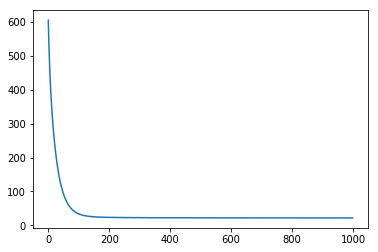

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)